# The Cournot Game 

* Two firms 1 and 2:
  * qA -> Quantity of firm A
  * qB -> Quantity of firm B


- Inverse demand:
$$p(q_A,q_B) = max \{ u - v (q_A + q_B), \; 0 \}$$

* Cost functions:
$$
c_A(q_A) = w q_A, \quad c_B(q_B) = w q_B
$$

- Profit function:
$$\pi_A(q_A,q_B) = q_A \;. \, max \{(u - v (q_A + q_B) - w), \; w \}$$
$$\pi_B(q_B,q_A) = q_B \;. \, max \{(u - v (q_A + q_B) - w), \; w \}$$

* Defining rewards of the game:
  
<div style="text-align: left; margin-bottom: 50px;"> 
    
|                      | Cournot  | Collusion  |
|----------------------|-------------- |---------------|
| **Quantity**    | $\frac{2(u-w)}{3v}$        | $\frac{(u-w)}{2v}$        |
| **Profit**       | $\frac{2(u-w)^2}{9v}$       | $\frac{(u-w)^2}{4v}$        |

   
</div>



### 1. Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

### 2. Set the Game

In [2]:
# Parameter values :
u = 40
v = 1
w = 4

# Inverse demand function
def price(q_A, q_B):
    return max(u - v * (q_A + q_B), 0)

# Cost functions
def cost_A(q_A):
    return w * q_A

def cost_B(q_B):
    return w * q_B

# Profit functions
def profit_A(q_A, q_B):
    return q_A * max(price(q_A, q_B) - w, - w)

def profit_B(q_B, q_1):
    return q_B * max(price(q_A, q_B) - w, - w)

# Range of possible quantities (0 to 40 for both firms)
q_range = np.arange(0, 41)

# Create payoff matrices for Player A (Firm 1) and Player B (Firm 2)
payoffs_A = np.zeros((len(q_range), len(q_range)))  # Payoff matrix for Firm 1
payoffs_B = np.zeros((len(q_range), len(q_range)))  # Payoff matrix for Firm 2

# Calculate the payoffs for each combination of quantities q1 and q2
for i, q_A in enumerate(q_range):
    for j, q_B in enumerate(q_range):
        payoffs_A[i, j] = profit_A(q_A, q_B)
        payoffs_B[i, j] = profit_B(q_B, q_A)

# Example: printing payoff matrix for Firm 1 (Player A)
print("Payoff matrix for Firm A:")
print(payoffs_A)

# Example: printing payoff matrix for Firm 2 (Player B)
print("Payoff matrix for Firm B:")
print(payoffs_B)


# Important outcomes
q_cournot = (2 * (u - w)) / (3 * v)
q_collusion = (u - w) / (2 * v)
q_walras = (u - w) / v

# Important outcomes for each firm
qi_cournot = q_cournot / 2
qi_collusion = q_collusion / 2
qi_walras = q_walras / 2

# Printing Cournot and Collusion quantities
print(" ")
print(f"Cournot quantity for firm i is {qi_cournot}")
print(" ")
print(f"Collusion quantity for firm i is {qi_collusion}")
print(" ")
print(f"Walras (zero profit) quantity for firm i is {qi_walras}")

Payoff matrix for Firm A:
[[   0.    0.    0. ...    0.    0.    0.]
 [  35.   34.   33. ...   -3.   -4.   -4.]
 [  68.   66.   64. ...   -8.   -8.   -8.]
 ...
 [ -76. -114. -152. ... -152. -152. -152.]
 [-117. -156. -156. ... -156. -156. -156.]
 [-160. -160. -160. ... -160. -160. -160.]]
Payoff matrix for Firm B:
[[   0.   35.   68. ...  -76. -117. -160.]
 [   0.   34.   66. ... -114. -156. -160.]
 [   0.   33.   64. ... -152. -156. -160.]
 ...
 [   0.   -3.   -8. ... -152. -156. -160.]
 [   0.   -4.   -8. ... -152. -156. -160.]
 [   0.   -4.   -8. ... -152. -156. -160.]]
 
Cournot quantity for firm i is 12.0
 
Collusion quantity for firm i is 9.0
 
Walras (zero profit) quantity for firm i is 18.0


### 3. Set the q-learning strategy

In [3]:
# Q-tables for both players
# One State - memoryless
Q_A = np.zeros((41, 1))  # It is 41 lines because the firms can choose 0 
Q_B = np.zeros((41, 1))

# Q-learning parameters
alpha = 0.50  # Learning rate
initial_temperature = 1000 # Temperature for exploration rate
decay_rate = 0.99999 # decay rate of temperature

# Simulation parameters
episodes = 500000


# Note: if we check for more episodes there will be an error of NaN with the "probabilities". 
# Basically, there should be a probablity that becomes null over time exceeding 500 000 episodes and it says NaN.

## CAREFUL: Quantity of 1 is Index 0 !!! 

### Bolzmann strategy 

Agent chooses action $a = C, D$ with probability:

$$
P(A) = \frac{exp(\hat{Q}(a)/T)}{\sum_{a'} exp(\hat{Q}(a')/T)}
$$

where temperature decay rate follows

$$
T = T_0 \times \epsilon^{n} 
$$

where $n$ denotes episode


In [4]:
# Helper function for Boltzmann action selection
def choose_quantity(Q_column, temperature):

    # Flatten column in 1-dim vector
    Q_column = Q_column.flatten()
    
    # Calculate the probabilities of selecting each action using Boltzmann distribution
    #exp_values = np.exp(Q_column / temperature)
    
    # Take relative Q-value to avoid Inf issues
    max_Q = np.max(Q_column)  # Get max Q value
    exp_values = np.exp((Q_column - max_Q) / temperature)  # Subtract max Q value
    probabilities = exp_values / np.sum(exp_values)

    # Select an action based on the computed probabilities
    if np.isnan(probabilities).any():
        raise ValueError("NaN detected in probabilities!", Q_column, exp_values, probabilities )

    return np.random.choice(len(Q_column), p=probabilities)


In [5]:
# Temperature decay function
def temperature_decay(initial_temperature, decay_rate, episode):
    return max(initial_temperature * (decay_rate ** episode), 0.0001)

In [6]:
# Q-learning function
def run_simulation(alpha, initial_temperature, decay_rate):

    # Track simulations result regarding cooperation rates
    track_quantity = []  
    total_q_A = 0
    total_q_B = 0
    
    for episode in range(1, episodes+1):
        # Decay temperature
        temperature = temperature_decay(initial_temperature, decay_rate, episode)
        
        # Choose actions
        quantity_A = choose_quantity(Q_A, temperature)
        quantity_B = choose_quantity(Q_B, temperature)
    
        
        # Get rewards
        reward_A = payoffs_A[quantity_A, quantity_B]
        reward_B = payoffs_B[quantity_A, quantity_B]
        
        
        # Update Q-tables
        Q_A[quantity_A] += alpha * (reward_A  - Q_A[quantity_A])
        Q_B[quantity_B] += alpha * (reward_B  - Q_B[quantity_B])
        
        # Track quantity (need to add +1 because quantity_A and quantity_B are indexed at 0 !!!!)
        total_q_A += quantity_A  
        total_q_B += quantity_B  
        
        # Track cooperation every 1000 episodes
        if episode % 1000 == 0:
            avg_q_A = total_q_A / 1000
            avg_q_B = total_q_B / 1000
            track_quantity.append({
                "episode": episode,
                "avg_q_A": avg_q_A,
                "avg_q_B": avg_q_B,
            })
            # Reset variables 
            total_q_A = 0
            total_q_B = 0
            
    return track_quantity

### 4. Test for one shot

In [7]:
%%time
data = run_simulation(alpha, initial_temperature, decay_rate)

CPU times: user 20.1 s, sys: 345 ms, total: 20.4 s
Wall time: 20.1 s


In [8]:
# Convert cooperation tracking to DataFrame
track_quantity_df = pd.DataFrame(data)

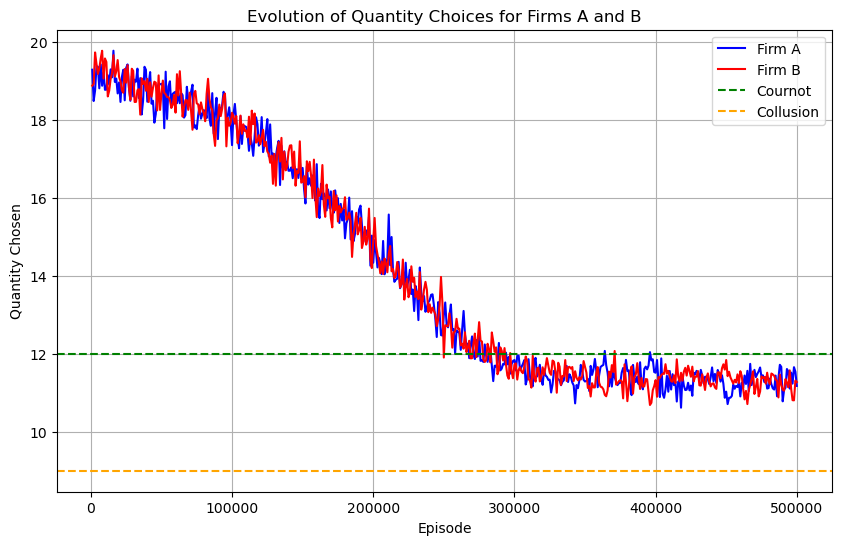

Cournot quantity is 12.0
Collusion quantity is 9.0


In [9]:
# Plot quantity choices
plt.figure(figsize=(10, 6))
plt.plot(track_quantity_df["episode"], track_quantity_df["avg_q_A"], label="Firm A", color="blue")
plt.plot(track_quantity_df["episode"], track_quantity_df["avg_q_B"], label="Firm B", color="red")
plt.axhline(y=qi_cournot, label="Cournot", color="green", linestyle="--")
plt.axhline(y=qi_collusion, label="Collusion", color="orange", linestyle="--")
plt.title("Evolution of Quantity Choices for Firms A and B")
plt.xlabel("Episode")
plt.ylabel("Quantity Chosen")
plt.legend()
plt.grid(True)
plt.show()



# Printing Cournot and Collusion quantities
print(f"Cournot quantity is {qi_cournot}")
print(f"Collusion quantity is {qi_collusion}")

In [13]:
track_quantity_df["avg_q_A"][480:]

480    11.365
481    11.214
482    11.112
483    11.082
484    11.440
485    10.910
486    11.384
487    11.717
488    11.664
489    10.780
490    11.078
491    11.129
492    11.609
493    11.547
494    11.108
495    11.517
496    11.234
497    11.656
498    11.540
499    11.176
Name: avg_q_A, dtype: float64

### 5. Run several repetitions of the q-learning

In [14]:
%%time

# Define the number of repetitions
repetitions = 30

# Use joblib to run `run_simulation` as parallel jobs
datasets = Parallel(n_jobs=-1)(delayed(run_simulation)(alpha, initial_temperature, decay_rate) for _ in range(repetitions))


CPU times: user 84.6 ms, sys: 91.6 ms, total: 176 ms
Wall time: 1min 18s


In [15]:
# Convert datasets into a single DataFrame
df_raw = pd.concat([pd.DataFrame(data) for data in datasets])

# Compute mean for each episode
df_mean = df_raw.groupby("episode", as_index=False)[["avg_q_A", "avg_q_B"]].mean()

# Rename columns for clarity
df_mean.rename(columns={"avg_q_A": "mean_avg_q_A", "avg_q_B": "mean_avg_q_B"}, inplace=True)

# Calculate moving averages (window=3)
df_mean["moving_avg_A"] = df_mean["mean_avg_q_A"].rolling(window=3).mean()
df_mean["moving_avg_B"] = df_mean["mean_avg_q_B"].rolling(window=3).mean()

# Display the result
print(df_mean.head())


   episode  mean_avg_q_A  mean_avg_q_B  moving_avg_A  moving_avg_B
0     1000     19.258767     19.097300           NaN           NaN
1     2000     19.039167     19.147233           NaN           NaN
2     3000     19.072167     19.119433     19.123367     19.121322
3     4000     19.252967     19.190200     19.121433     19.152289
4     5000     19.078400     19.340400     19.134511     19.216678


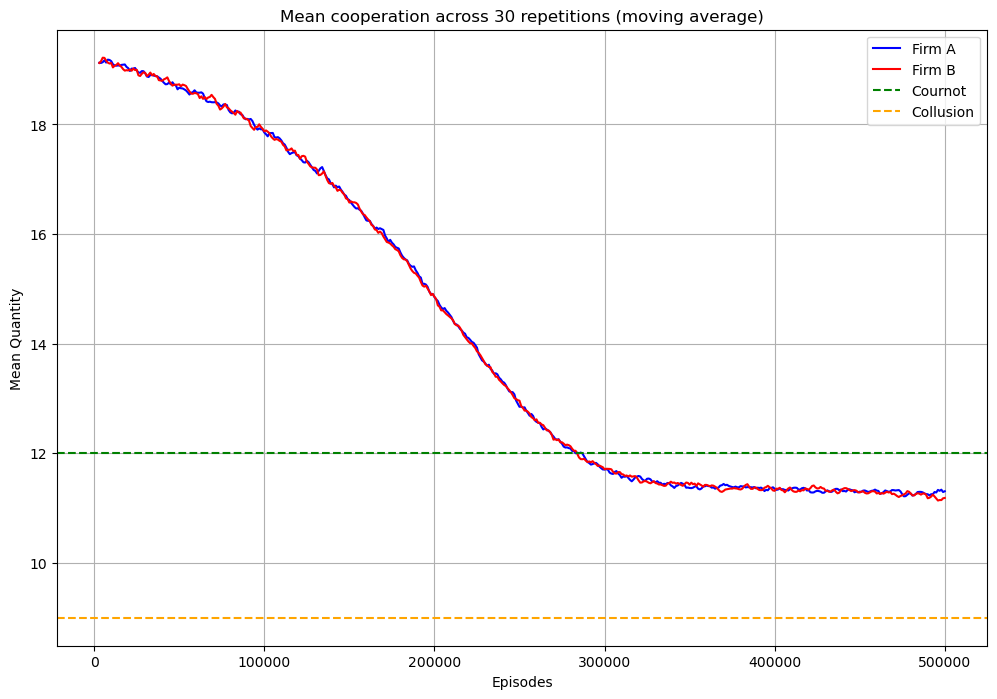

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(df_mean['episode'], df_mean['moving_avg_A'], label='Firm A', linestyle='-', color='blue')
plt.plot(df_mean['episode'], df_mean['moving_avg_B'], label='Firm B', linestyle='-', color='red')
plt.xlabel('Episodes')
plt.ylabel('Mean Quantity')
plt.title(f'Mean cooperation across {repetitions} repetitions (moving average)')
plt.axhline(y=qi_cournot, label="Cournot", color="green", linestyle="--")
plt.axhline(y=qi_collusion, label="Collusion", color="orange", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

### Graph with confidence intervals

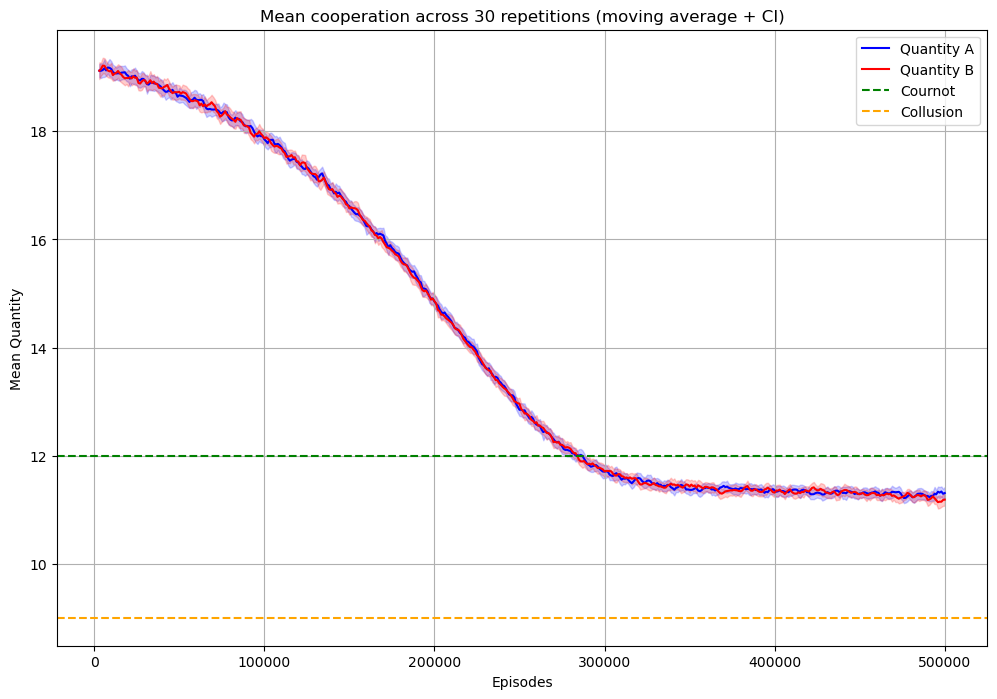

In [17]:
# Convert datasets into a single DataFrame
df = pd.concat([pd.DataFrame(data) for data in datasets])

# Compute mean and standard deviation for each episode
df_stats = df.groupby("episode", as_index=False).agg(
    mean_avg_q_A=("avg_q_A", "mean"),
    mean_avg_q_B=("avg_q_B", "mean"),
    std_avg_q_A=("avg_q_A", "std"),
    std_avg_q_B=("avg_q_B", "std")
)

# Compute confidence intervals (95%)
df_stats["ci_avg_q_A"] = 1.96 * df_stats["std_avg_q_A"] / np.sqrt(repetitions)
df_stats["ci_avg_q_B"] = 1.96 * df_stats["std_avg_q_B"] / np.sqrt(repetitions)

# Compute moving averages
df_stats["moving_avg_A"] = df_stats["mean_avg_q_A"].rolling(window=3).mean()
df_stats["moving_avg_B"] = df_stats["mean_avg_q_B"].rolling(window=3).mean()

# Plot with confidence intervals
plt.figure(figsize=(12, 8))

# Plot Mean with Confidence Interval for A
plt.plot(df_stats['episode'], df_stats['moving_avg_A'], label='Quantity A', color='blue')
plt.fill_between(df_stats['episode'], 
                 df_stats['moving_avg_A'] - df_stats["ci_avg_q_A"], 
                 df_stats['moving_avg_A'] + df_stats["ci_avg_q_A"], 
                 color='blue', alpha=0.2)

# Plot Mean with Confidence Interval for B
plt.plot(df_stats['episode'], df_stats['moving_avg_B'], label='Quantity B', color='red')
plt.fill_between(df_stats['episode'], 
                 df_stats['moving_avg_B'] - df_stats["ci_avg_q_B"], 
                 df_stats['moving_avg_B'] + df_stats["ci_avg_q_B"], 
                 color='red', alpha=0.2)

# Add quantity references for Cournot and Collusion
plt.axhline(y=qi_cournot, label="Cournot", color="green", linestyle="--")
plt.axhline(y=qi_collusion, label="Collusion", color="orange", linestyle="--")

plt.xlabel('Episodes')
plt.ylabel('Mean Quantity')
plt.title(f'Mean cooperation across {repetitions} repetitions (moving average + CI)')
plt.legend()
plt.grid(True)
plt.show()
